In [43]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from XANES2020_code.general_tools import imagesc
from XANES2020_code.paths import DATA_FOLDER, CAL_DATA
from XANES2020_code.Espec.espec_processing import ESpec_high_proc


In [41]:
# # 20200927/run01
# imgP_pix = np.array([[2162, 956],[1269, 925],[628,902],[602,1390],[1243,1411],[2077,1443]]) # pixel values
# imgP_real =np.array([[0 ,76.5],[140 ,76.5],[240 ,76.5],[240 ,0.5],[140 ,0.5 ],[10, 0.5]]) # physical values (i.e. in cm)

# for 28th Aug
# imgP_pix = imgP_pix*1.0
# imgP_pix[:,0] = imgP_pix[:,0]+30

# for 7th Sept
# imgP_pix[:,0] = imgP_pix[:,0]+135

# for 29th Sept
imgP_pix = np.array([[2375,544],[1361,571],[643,587 ],[646,1138],[1367,1120],[2308,1099]]) # pixel values
imgP_real =np.array([[0 ,76.5],[140 ,76.5],[240,76.5],[240 ,0.5],[140 ,0.5 ],[10, 0.5]]) # physical values (i.e. in cm)


Nx_new = 4000
Ny_new = 960

# physical range covered by output image
xRange = 400
yRange = 106 
x0 = -50
y0 = -15

# physical resolution of output image
dx = xRange/Nx_new
dy = yRange/Ny_new
x_mm = x0 + np.linspace(0,Nx_new,num=Nx_new)*dx
y_mm = y0 + np.linspace(0,Ny_new,num=Ny_new)*dy

# Pixel values in new image
imgP_trans = (imgP_real-[x0,y0]) / [dx,dy]

H, status = cv2.findHomography(imgP_pix,imgP_trans)



c:\users\clfuser\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
c:\users\clfuser\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


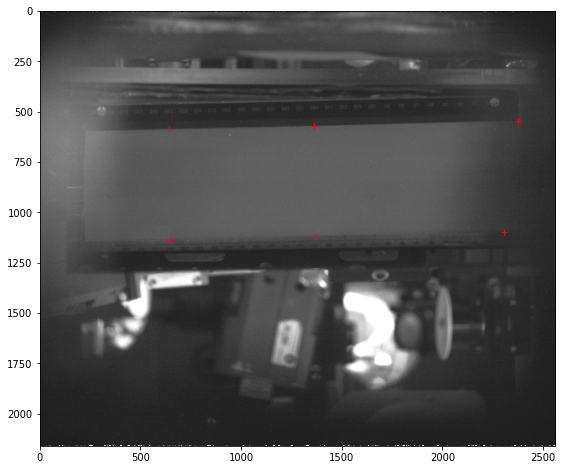

In [42]:
calib_path = os.path.join(os.path.split(DATA_FOLDER)[0],'calib')
testFile = os.path.join(calib_path,r'/Espec_high/20200825/20200825_1837_lights.tiff')
testFile = os.path.join(calib_path,r'/Espec_high/20200828/20200828_Espec_high_ref.tif')
testFile = os.path.join(DATA_FOLDER,'Espec_high/20200907/run01/Shot049.tif')
testFile = os.path.join(calib_path,r'Espec_high/20200929/20200929_1257.TIFF')


20201005
# first shot to which calibration will apply  
run_shot_str = '20200929_run01_shot001'

img = plt.imread(testFile)
(Ny,Nx) = np.shape(img)

# calculate pixel areas in original image
retval,H_inv = cv2.invert(H)
(X,Y) = np.meshgrid(x_mm,y_mm)
X_raw = cv2.warpPerspective(X, H_inv, (Nx,Ny))
Y_raw = cv2.warpPerspective(Y, H_inv, (Nx,Ny))
imgArea0 = np.gradient(X_raw,axis=1)*np.gradient(Y_raw,axis=0)

# calc transformed image
imgCountsPerArea = img/imgArea0
imgCountsPerArea[imgArea0==0] =0
imgCountsPerArea[np.isinf(imgCountsPerArea)] = 0
imgCountsPerArea[np.isnan(imgCountsPerArea)] = 0

im_out = cv2.warpPerspective(imgCountsPerArea, H, (Nx_new,Ny_new))*dx*dy

import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        


tForm = {  
    'description': 'Espec1 image transform',
    'H': H,
    'newImgSize':(Nx_new,Ny_new),
    'x_mm': x_mm,
    'y_mm': y_mm,
    'imgArea0': np.median(imgArea0[np.abs(X_raw**2+Y_raw**2)>0]),
    'imgArea1': dx*dy
}
tForm_filepath = os.path.join(CAL_DATA,'Espec_high','Espec_high_transform_' + run_shot_str + '.pkl')

# save_object(tForm, tForm_filepath)
# Display image
plt.figure(figsize=(28,8))
plt.imshow(img,cmap='Greys_r',vmax=1000)
plt.plot(imgP_pix[:,0],imgP_pix[:,1],'r+')


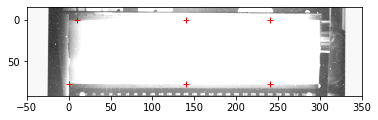

In [39]:
Espec_cal_filepath = os.path.join(CAL_DATA,'Espec_high',r'Espec_high_disp_cal_20200825_run01_shot001.mat')

ep = ESpec_high_proc(tForm_filepath,Espec_cal_filepath,img_bkg=None,use_median=True,kernel_size=None )
im_out2 = ep.espec_warp(img)
plt.imshow(im_out2,extent= (np.min(x_mm), np.max(x_mm), np.max(y_mm), np.min(y_mm)),cmap='Greys_r',vmax=1000)
plt.plot(imgP_real[:,0],imgP_real[:,1],'r+')
plt.clim((None,10))


In [6]:
tForm['x_mm']

array([-50.        , -49.89997499, -49.79994999, ..., 349.79994999,
       349.89997499, 350.        ])